In [2]:
# Pour importer les outils
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import random
import keras
from tensorflow.keras import datasets, layers, models, Model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import files
import cv2
from matplotlib import pyplot
import h5py
from tensorflow.keras.utils import img_to_array

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


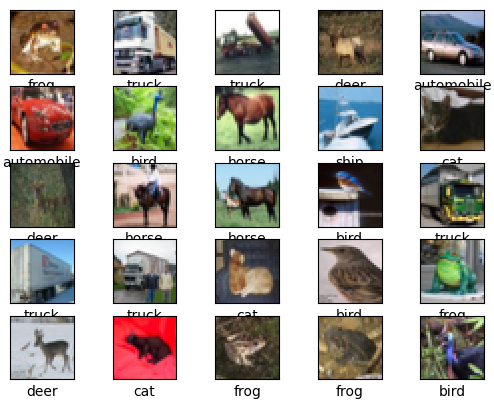

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])  
    plt.yticks([])  
    plt.grid(False) 
    plt.imshow(train_images[i]) 
    plt.xlabel(class_names[train_labels[i][0]]) 

plt.show()


In [5]:
# Define the Inverted Residual Block for MobileNetV2
def inverted_res_block(inputs, expansion, filters, stride, block_id):
    in_channels = inputs.shape[-1]
    prefix = f'block_{block_id}_'
    x = inputs
    # Expansion phase: If expansion != 1, use a 1x1 convolution to expand the number of channels.
    if expansion != 1:
        x = layers.Conv2D(in_channels * expansion, kernel_size=1, padding='same', use_bias=False,
                          name=prefix+'expand_conv')(x)
        x = layers.BatchNormalization(name=prefix+'expand_bn')(x)
        x = layers.ReLU(6., name=prefix+'expand_relu')(x)
    # Depthwise separable convolution (Depthwise Conv)
    x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False,
                               name=prefix+'dw_conv')(x)
    x = layers.BatchNormalization(name=prefix+'dw_bn')(x)
    x = layers.ReLU(6., name=prefix+'dw_relu')(x)
    # Projection phase: Use a 1x1 convolution to reduce the number of channels to the target.
    x = layers.Conv2D(filters, kernel_size=1, padding='same', use_bias=False,
                      name=prefix+'project_conv')(x)
    x = layers.BatchNormalization(name=prefix+'project_bn')(x)
    # When stride is 1 and the number of input channels equals the number of output channels, add a residual connection.
    if stride == 1 and in_channels == filters:
        x = layers.Add(name=prefix+'add')([inputs, x])
    return x

# Build the MobileNetV2 model for CIFAR-10 (input size 32x32), with an adjusted downsampling strategy.
def build_mobilenetv2_cifar10(input_shape=(32,32,3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Initial convolutional layer, without downsampling (since CIFAR-10 images are small)
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', use_bias=False, name='initial_conv')(inputs)
    x = layers.BatchNormalization(name='initial_bn')(x)
    x = layers.ReLU(6., name='initial_relu')(x)

    block_id = 0
    # Stage 1: 1 block, t=1, c=16, stride=1
    x = inverted_res_block(x, expansion=1, filters=16, stride=1, block_id=block_id)
    block_id += 1

    # Stage 2: 2 blocks, t=6, c=24, the first block with stride 2 (downsampling), the second block with stride 1
    x = inverted_res_block(x, expansion=6, filters=24, stride=2, block_id=block_id)
    block_id += 1
    x = inverted_res_block(x, expansion=6, filters=24, stride=1, block_id=block_id)
    block_id += 1

    # Stage 3: 3 blocks, t=6, c=32, the first block with stride 2, subsequent blocks with stride 1
    x = inverted_res_block(x, expansion=6, filters=32, stride=2, block_id=block_id)
    block_id += 1
    x = inverted_res_block(x, expansion=6, filters=32, stride=1, block_id=block_id)
    block_id += 1
    x = inverted_res_block(x, expansion=6, filters=32, stride=1, block_id=block_id)
    block_id += 1

    # Stage 4: 4 blocks, t=6, c=64; to prevent feature maps from becoming too small, no downsampling is applied (stride=1 for all blocks)
    x = inverted_res_block(x, expansion=6, filters=64, stride=1, block_id=block_id)
    block_id += 1
    x = inverted_res_block(x, expansion=6, filters=64, stride=1, block_id=block_id)
    block_id += 1
    x = inverted_res_block(x, expansion=6, filters=64, stride=1, block_id=block_id)
    block_id += 1
    x = inverted_res_block(x, expansion=6, filters=64, stride=1, block_id=block_id)
    block_id += 1

    # Final convolutional layer (1x1 convolution); the number of channels is not further increased significantly here.
    x = layers.Conv2D(1280, kernel_size=1, padding='same', use_bias=False, name='final_conv')(x)
    x = layers.BatchNormalization(name='final_bn')(x)
    x = layers.ReLU(6., name='final_relu')(x)

    # Global average pooling and classifier.
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = models.Model(inputs, outputs, name="MobileNetV2_CIFAR10")
    return model

# Create the model.
model = build_mobilenetv2_cifar10()


In [6]:
#Pour afficher l'architecture du modele CNN 打印模型结构
model.summary()


Model: "MobileNetV2_CIFAR10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ initial_conv (Conv2D)     │ (None, 32, 32, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ initial_bn                │ (None, 32, 32, 32)     │            128 │ initial_conv[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ initial_relu (ReLU)       │ (None, 32, 32, 32)     │              0 │ initial_bn[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_0_dw_conv           │ (None, 32, 32, 32)     │            288 │ initial_relu[0][0]     │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_0_dw_bn             │ (None, 32, 32, 32)     │            128 │ block_0_dw_conv[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_0_dw_relu (ReLU)    │ (None, 32, 32, 32)     │              0 │ block_0_dw_bn[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_0_project_conv      │ (None, 32, 32, 16)     │            512 │ block_0_dw_relu[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_0_project_bn        │ (None, 32, 32, 16)     │             64 │ block_0_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_conv       │ (None, 32, 32, 96)     │          1,536 │ block_0_project_bn[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_bn         │ (None, 32, 32, 96)     │            384 │ block_1_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 32, 32, 96)     │              0 │ block_1_expand_bn[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_dw_conv           │ (None, 16, 16, 96)     │            864 │ block_1_expand_relu[0… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_dw_bn             │ (None, 16, 16, 96)     │            384 │ block_1_dw_conv[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_dw_relu (ReLU

 Total params: 348,618 (1.33 MB)

 Trainable params: 336,650 (1.28 MB)

 Non-trainable params: 11,968 (46.75 KB)

In [7]:

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) 

history = model.fit(train_images, train_labels,
                    epochs=50, 
                    validation_data=(test_images, test_labels))


#model.save(r"C:\Users\Clay\Desktop\Multimedia Networking\Biometric\TP-CNN\modal\model.h5")

model.save("model.h5")

files.download("model.h5")


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 24ms/step - accuracy: 0.4153 - loss: 1.5995 - val_accuracy: 0.5201 - val_loss: 1.6578
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.6541 - loss: 0.9778 - val_accuracy: 0.6808 - val_loss: 0.9444
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.7335 - loss: 0.7626 - val_accuracy: 0.7443 - val_loss: 0.7370
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.7768 - loss: 0.6405 - val_accuracy: 0.7590 - val_loss: 0.7127
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8056 - loss: 0.5647 - val_accuracy: 0.7495 - val_loss: 0.7674
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8270 - loss: 0.4970 - val_accuracy: 0.7891 - val_loss: 0.6281
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8441 - loss: 0.4440 - val_accuracy: 0.7647 - val_loss: 0.7149
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8594 -

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:

history_dict = history.history

df = pd.DataFrame({
    "Train_accuracy": history_dict["accuracy"],
    "Train_loss": history_dict["loss"],
    "Test_accuracy": history_dict["val_accuracy"],
    "Test_loss": history_dict["val_loss"]
})

excel_filename = "training_history.xlsx"
df.to_excel(excel_filename, index=False)

print(f"已保存到 Excel 文件: {excel_filename}")

files.download(excel_filename)

已保存到 Excel 文件: training_history.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
model=load_model("model.h5")

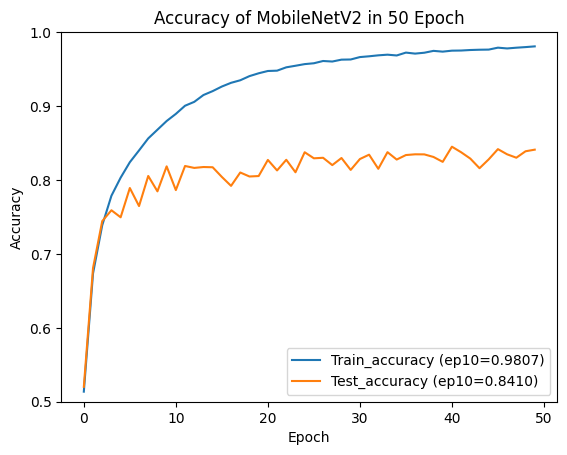

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

313/313 - 1s - 5ms/step - accuracy: 0.8410 - loss: 0.7799

Test accuracy: 0.8410


In [15]:
train_acc_10 = history.history['accuracy'][-1]
test_acc_10  = history.history['val_accuracy'][-1]

#  (accuracy vs. epochs)
plt.plot(history.history['accuracy'],
         label=f"Train_accuracy (ep10={train_acc_10:.4f})") 
plt.plot(history.history['val_accuracy'],
         label=f"Test_accuracy (ep10={test_acc_10:.4f})") 
plt.xlabel('Epoch')  
plt.ylabel('Accuracy') y
plt.ylim([0.5, 1]) 
plt.legend(loc='lower right')  
plt.title("Accuracy of MobileNetV2 in 50 Epoch")

plt.savefig("accuracy_MobileNetV2.png", dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

files.download("accuracy_MobileNetV2.png")

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}") 


In [11]:
print(test_acc)

0.8410000205039978


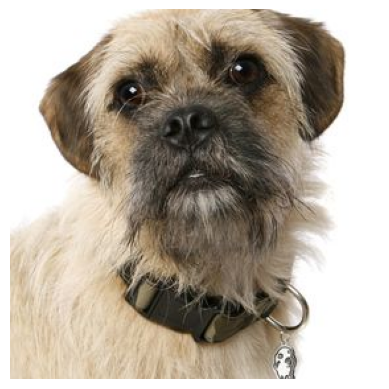

In [12]:

img = cv2.imread(r"/content/chien.jpg") 

img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_cvt)
plt.axis('off') 
plt.show()


In [13]:
img = cv2.resize(img_cvt, (32,32))
img = img.astype('float32')
img= img / 255.0
imgs = tf.expand_dims(
    img,
    axis=0,
    name=None
)
model.predict(imgs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[7.1916602e-08, 1.6132767e-10, 5.1638577e-02, 5.5050557e-03,
        2.2713575e-05, 5.6001707e-04, 9.4227260e-01, 1.0602854e-06,
        2.9719454e-12, 2.5151966e-11]], dtype=float32)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ initial_conv (Conv2D)                │ (None, 32, 32, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ initial_bn (BatchNormalization)      │ (None, 32, 32, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ initial_relu (ReLU)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block_0_dw_conv (DepthwiseConv2D)    │ (None, 32, 32, 32)          │             288 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280 (5.00 KB)

 Trainable params: 1,216 (4.75 KB)

 Non-trainable params: 64 (256.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


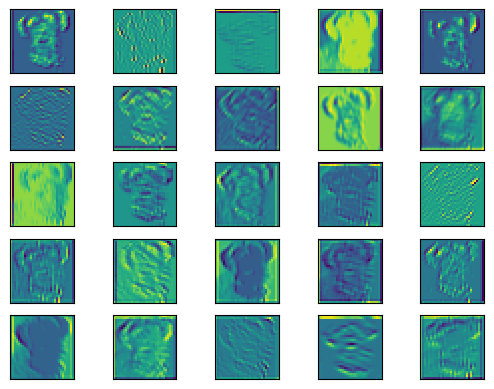

In [14]:


i=4


square = 5
ix = 1

model2 = Model(inputs=model.inputs, outputs=model.layers[i].output)

model2.summary()

feature_maps = model2.predict(imgs)
    
for _ in range(square):
  for _ in range(square):
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])  
        ax.set_yticks([]) 
        
        pyplot.imshow(feature_maps[0, :, :, ix-1])

        ix += 1

pyplot.show()
